In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib
import gc
import sys
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [2]:
def create_movie(field_time_out, monitor_lambdas,name='',type='t',log=False,path="",frames_per_second=1,rem_frames=False, normalize=True, a=5/3):
    frames = []

    max_values = field_time_out.max(axis=(0,1,2)) if normalize else 1

    field_time_out = field_time_out/max_values
    field_time_out['x'] = field_time_out['x']/a
    field_time_out['y'] = field_time_out['y']/a
    field_time_out['z'] = field_time_out['z']/a


    if log:
        field_log = np.log10((field_time_out))
        folder_pics = "logPics"
        
    else:
        field_log = ((field_time_out))
        folder_pics = "linPics"

    if not os.path.exists(f'{path}/{folder_pics}'):
            os.makedirs(f'{path}/{folder_pics}')
            print(f"Folder {path}/{folder_pics} created successfully.")




    for i in range(np.shape(field_time_out)[-1]):
        if os.path.isfile(f'{path}/{folder_pics}/frame_{i}.png'):
            frames.append(f'{path}/{folder_pics}/frame_{i}.png')
            continue
        try:
            fig, ax = plt.subplots(figsize=(14/2, 18/2))
            #fig, ax = plt.subplots(figsize=(12, 6))
            if type=="t":
                pcolormesh = (field_log).isel(t=i).squeeze().plot.pcolormesh(ax=ax,cmap="jet")
            else:
                pcolormesh = (field_log).isel(f=i).squeeze().plot.pcolormesh(ax=ax,cmap="jet")

            ax.set_aspect('auto', adjustable='box')
            #plt.ylim(-50,50)
            try:
                plt.title(f'Time: {str(np.array(field_time_out['t'][()][i])*1e12)} ps')
            except:
                plt.title(f'$\\nu$: {(1/np.array(td.C_0/field_time_out['f'][()][i])):.4g}')


            # Save the frame
            plt.savefig(f'{path}/{folder_pics}/frame_{i}.png')
            plt.close(fig)
            frames.append(f'{path}/{folder_pics}/frame_{i}.png')
        except:
            break
        

    name_movie = f'{path}/{name}.mp4' if name else f'output/anderson/d(t) analysis/Diameter d(t) at output of the structure Range - {monitor_lambdas[0]:.3g} - {monitor_lambdas[-1]:.3g}.mp4'
    with imageio.get_writer(name_movie, fps=frames_per_second) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # Optionally, remove the individual frames if no longer needed
    if rem_frames:
        for frame in frames:
            os.remove(frame)
    
    return False

In [3]:
import scipy.integrate
def IPR(intensity_array,x,y):
    intensity = intensity_array
    integral_1 = scipy.integrate.trapezoid(scipy.integrate.trapezoid(intensity**2, x=y, axis=1), x=x, axis=0)
    integral_2 = scipy.integrate.trapezoid(scipy.integrate.trapezoid(intensity, x=y, axis=1), x=x, axis=0)**2

    return ((integral_1/integral_2))

In [15]:
a=1
chi = [0.2,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40]

In [5]:
folders = [
        # rf"H:\phd stuff\tidy3d\data\09_11_2024 Beam Spreading 0.18 - 0.52 Larger Cell",
        # rf"H:\phd stuff\tidy3d\data\09_11_2024 Beam Spreading 0.18 - 0.52"
        # rf"H:\phd stuff\tidy3d\data\09_12_2024 Beam Spreading 0.2 - 0.48 Average"
        # rf"H:\phd stuff\tidy3d\data\09_13_2024 Beam Spreading 0.15 - 0.3 Average"
        rf"H:\phd stuff\tidy3d\data\09_13_2024 Beam Spreading 0.24 - 0.44 Average"
        # rf"H:\phd stuff\tidy3d\data\09_13_2024 Beam Spreading 0.24 - 0.44 Average Periodic Conditions"
    ]

for item in folders:
    folder_path = item
    # fig2, axs2 = plt.subplots(len(chi)+1, 1, figsize=(15, 10), sharex=True)o
    
    data = []
    for i,foldername in enumerate(natsorted(os.listdir(folder_path))):
        intensities = []
        xis = []
        print(foldername)
        # plt.figure(figsize=(15, 10))
        file=os.path.join(folder_path, foldername)
        samples = []
        for j,filename in enumerate(natsorted(os.listdir(file))):
            print(filename)

            samples += [j]
            fileSim=os.path.join(file, filename)
            sim_result = (AM.loadFromFile(key = tidy3dAPI, file_path=fileSim))
            intensity = sim_result.sim_data.get_intensity("freq_monitorFieldOut")
            lambdas = 1/sim_result.monitor_lambdas



            #create_movie(intensity,a/lambdas,name=f"logfreqmonitor {lambdas[0]:.3g} - {lambdas[-1]:.3g}",type="f",log=True,path=rf"H:\phd stuff\tidy3d\output/2D SHU/Freq Test Spreading/{Path(filename).stem}",frames_per_second=1,normalize=True,a=a)



            intensity_slab =  intensity[np.where(np.bool_(intensity["x"]>=-50) & np.bool_(intensity["x"]<=50))[0],np.where(np.bool_(intensity["y"]>=-12.45) & np.bool_(intensity["y"]<=12.45))[0],:,:]*1e16
            intensities += [intensity_slab]
            xis +=[2*np.sqrt(IPR(intensity_slab,intensity_slab.x,intensity_slab.y).squeeze())]
            # plt.scatter(intensity.f/td.C_0,2*np.sqrt(IPR(intensity_slab,intensity_slab.x,intensity_slab.y).squeeze()), label = Path(filename).stem)
        data += [{"xis_slabs":xis,"intensities_slab":intensities,"data":np.mean(intensities,axis=0),"lambdas":lambdas, "foldername":foldername,"xis":np.mean(xis,axis=0),"chi":chi[i], "samples":samples},]
        # plt.plot(intensity.f/td.C_0,np.mean(xis,axis=0),"--bo",label=fr"Mean $a/\xi$",color="#000435")
        # plt.legend()
        # plt.grid()
        # plt.xlabel(fr"$\nu$")
        # plt.ylabel(fr"$a/\xi$")
        # plt.show()
        
       
        # samples_xi = xr.DataArray(np.array(xis), coords={"f": (sim_result.sim_data.get_intensity("freq_monitorFieldOut").f)/td.C_0,"Sample Number":np.array(samples)}, dims=["Sample Number","f"])


        # fig, ax = plt.subplots(figsize=(14,9))
        # colors = [
        #   (1, 1, 1),  # White
        #   (0, 0, 1),  # Blue
        #   (1, 1, 0),  # Yellow
        #   (0, 1, 0),  # Green
        #   (1, 0, 0)]  # Red

        # n_bins = 500  # Number of bins for smooth transition
        # cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
        # # samples_xi = xr.DataArray(np.array(xis), coords={"f": (sim_result.sim_data.get_intensity("freq_monitorFieldOut").f)/td.C_0,"Sample Number":np.array(samples)}, dims=["Sample Number","f"])
        # f = (sim_result.sim_data.get_intensity("freq_monitorFieldOut").f)/td.C_0
        # # im = samples_xi.plot.pcolormesh(ax=ax, cmap=cmap, add_colorbar=False)
        # im=plt.imshow(np.array(xis), vmin = np.min(xis), vmax = np.max(xis), 
        #                  extent =[np.min(f),np.max(f), np.min(samples),np.max(samples)], 
        #                     interpolation ='bilinear', origin ='lower', cmap=cmap,aspect='auto') 
        # # Add colorbar
        # cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04,label=rf"$a/ \xi$")
        # plt.xlabel(rf"$\nu$")
        # plt.ylabel(rf"Sample Number")
        # plt.title(rf"$\chi={chi[i]}$")
        # plt.tight_layout()
        # plt.show()



chi_0.20_N_10000_posics
chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:42 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:44 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:47 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:50 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:52 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:55 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:28:58 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:01 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:03 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:06 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:09 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:12 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:15 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:17 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:20 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.20_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:23 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics
chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:27 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:29 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:32 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:35 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:38 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:41 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:44 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:47 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:49 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:52 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:55 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:29:58 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:01 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:04 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:07 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.30_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:09 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics
chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:13 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:16 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:19 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:22 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:25 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:27 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:30 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:33 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:36 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:39 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:42 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:45 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:48 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:50 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:53 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.31_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:30:56 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics
chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:00 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:03 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:05 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:08 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:11 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:14 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:17 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:20 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:23 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:26 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:29 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:32 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:35 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:38 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:40 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.32_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:43 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics
chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:47 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:50 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:53 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:56 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:31:58 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:01 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:04 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:07 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:10 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:13 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:16 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:19 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:22 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:25 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:28 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.33_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:30 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics
chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:34 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:37 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:40 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:43 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:46 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:48 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:51 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:54 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:32:57 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:00 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:03 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:06 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:09 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:12 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:15 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.34_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:18 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics
chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:21 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:24 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:27 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:30 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:33 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:36 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:39 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:42 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:45 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:47 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:50 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:53 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:56 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:33:59 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:02 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.35_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:05 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics
chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:09 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:12 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:14 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:17 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:20 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:23 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:26 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:29 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:32 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:35 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:38 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:41 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:44 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:47 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:50 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.36_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:53 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics
chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:56 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:34:59 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:02 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:05 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:08 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:11 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:14 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:17 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:20 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:23 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:26 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:29 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:31 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:34 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:37 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.37_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:40 W. Europe Daylight Time Billed flex credit cost: 0.565.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics
chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:44 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:47 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:50 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:53 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:56 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:35:59 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:02 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:04 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:07 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:10 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:13 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:16 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:19 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:22 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:25 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.38_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:28 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics
chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:32 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:35 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:38 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:41 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:44 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:47 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:49 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:52 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:55 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:36:58 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:01 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:04 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:07 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:10 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:13 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.39_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:16 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics
chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_0 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:20 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_1 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:23 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_2 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:26 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_3 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:29 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_4 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:32 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_5 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:35 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_6 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:38 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_7 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:41 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_8 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:44 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_9 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:47 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_10 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:50 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_11 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:53 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_12 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:56 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_13 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:37:59 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_14 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:38:02 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

chi_0.40_N_10000_posics Beam Spreading 0.24 - 0.44 - Sample_15 50.0ps.txt
Configured successfully.
No Reference Simulation was found for this case


12:38:05 W. Europe Daylight Time Billed flex credit cost: 0.564.

                                 Note: the task cost pro-rated due to early     
                                 shutoff was below the minimum threshold, due to
                                 fast shutoff. Decreasing the simulation        
                                 'run_time' should decrease the estimated, and  
                                 correspondingly the billed cost of such tasks.

In [6]:
chi

[0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4]

C:\Users\HernandF\AppData\Local\Temp\ipykernel_31304\1617867433.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(intensity.f/td.C_0,np.mean(item["xis_slabs"],axis=0),"--bo",label=fr"Mean $a/\xi$",color="#000435")


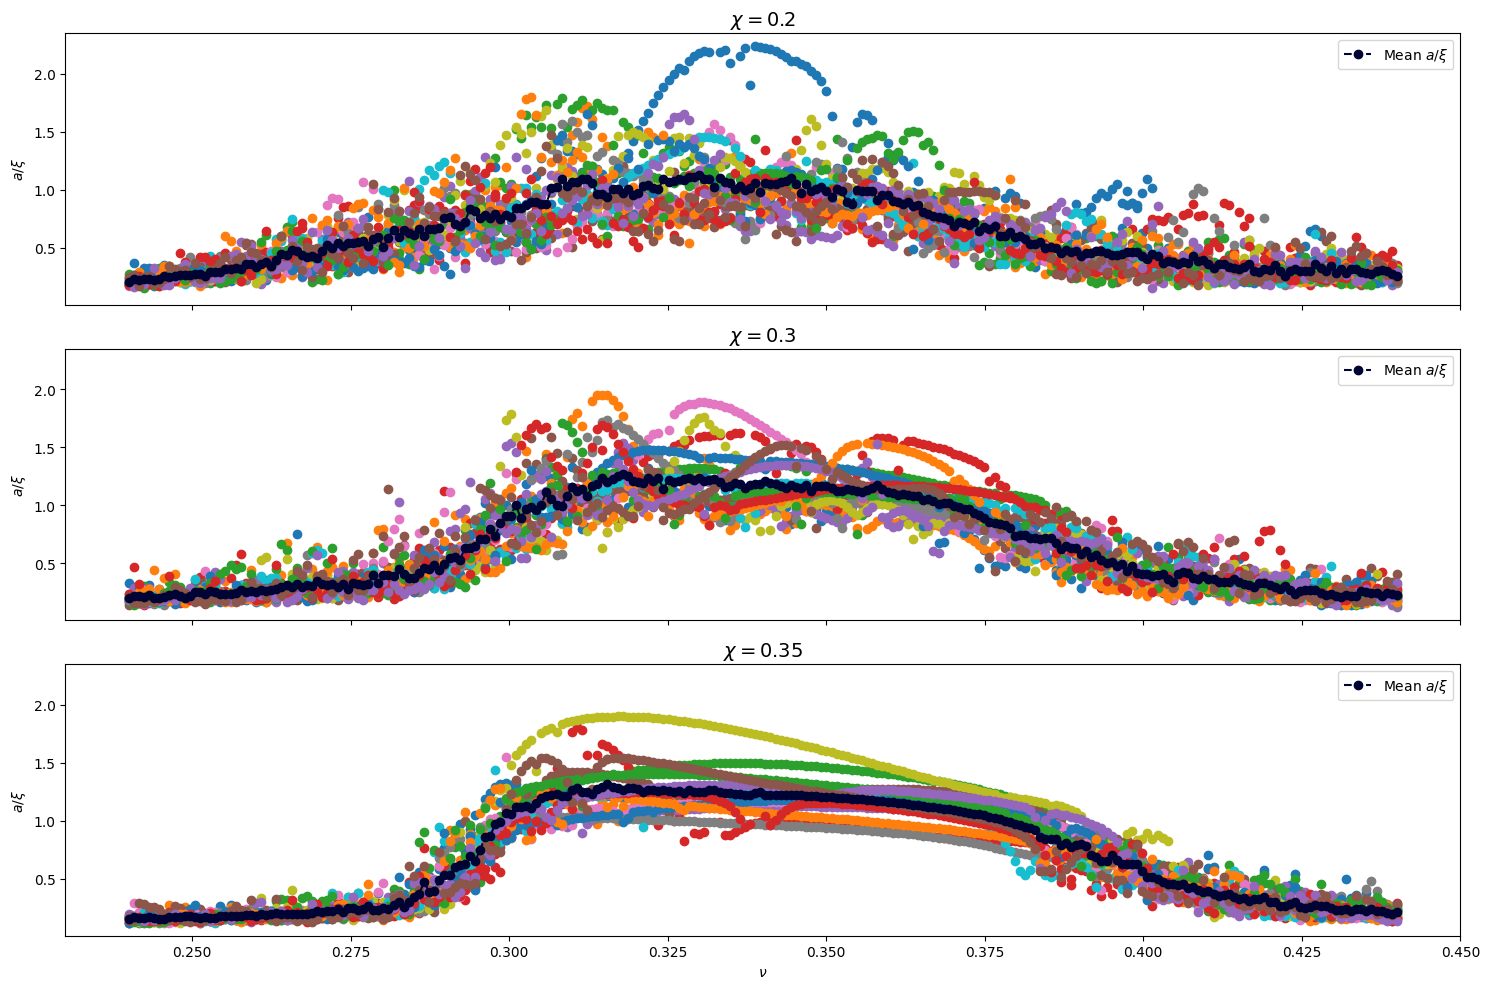

In [16]:
fig1, axs1 = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
# fig1, axs1 = plt.subplots(np.shape(data)[0], 1, figsize=(10, 30), sharex=True, sharey=True)
j=0
for i,item in enumerate(data):
 if not chi[i] in [0.2,0.3,0.35]:
   continue
 
 ax = axs1[j]
 j=j+1

 for xi_slab in item["xis_slabs"]:
    ax.scatter(intensity.f/td.C_0,xi_slab)
 
 ax.plot(intensity.f/td.C_0,np.mean(item["xis_slabs"],axis=0),"--bo",label=fr"Mean $a/\xi$",color="#000435")
 
 ax.legend()

 
 ax.set_title(rf"$\chi = {item["chi"]}$", fontsize=14)
 ax.set_ylabel(rf"$a/\xi$")

plt.xlabel(rf"$\nu$")
plt.tight_layout()

plt.show()
    

C:\Users\HernandF\AppData\Local\Temp\ipykernel_31304\2128469989.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig1.legend(fontsize="20")


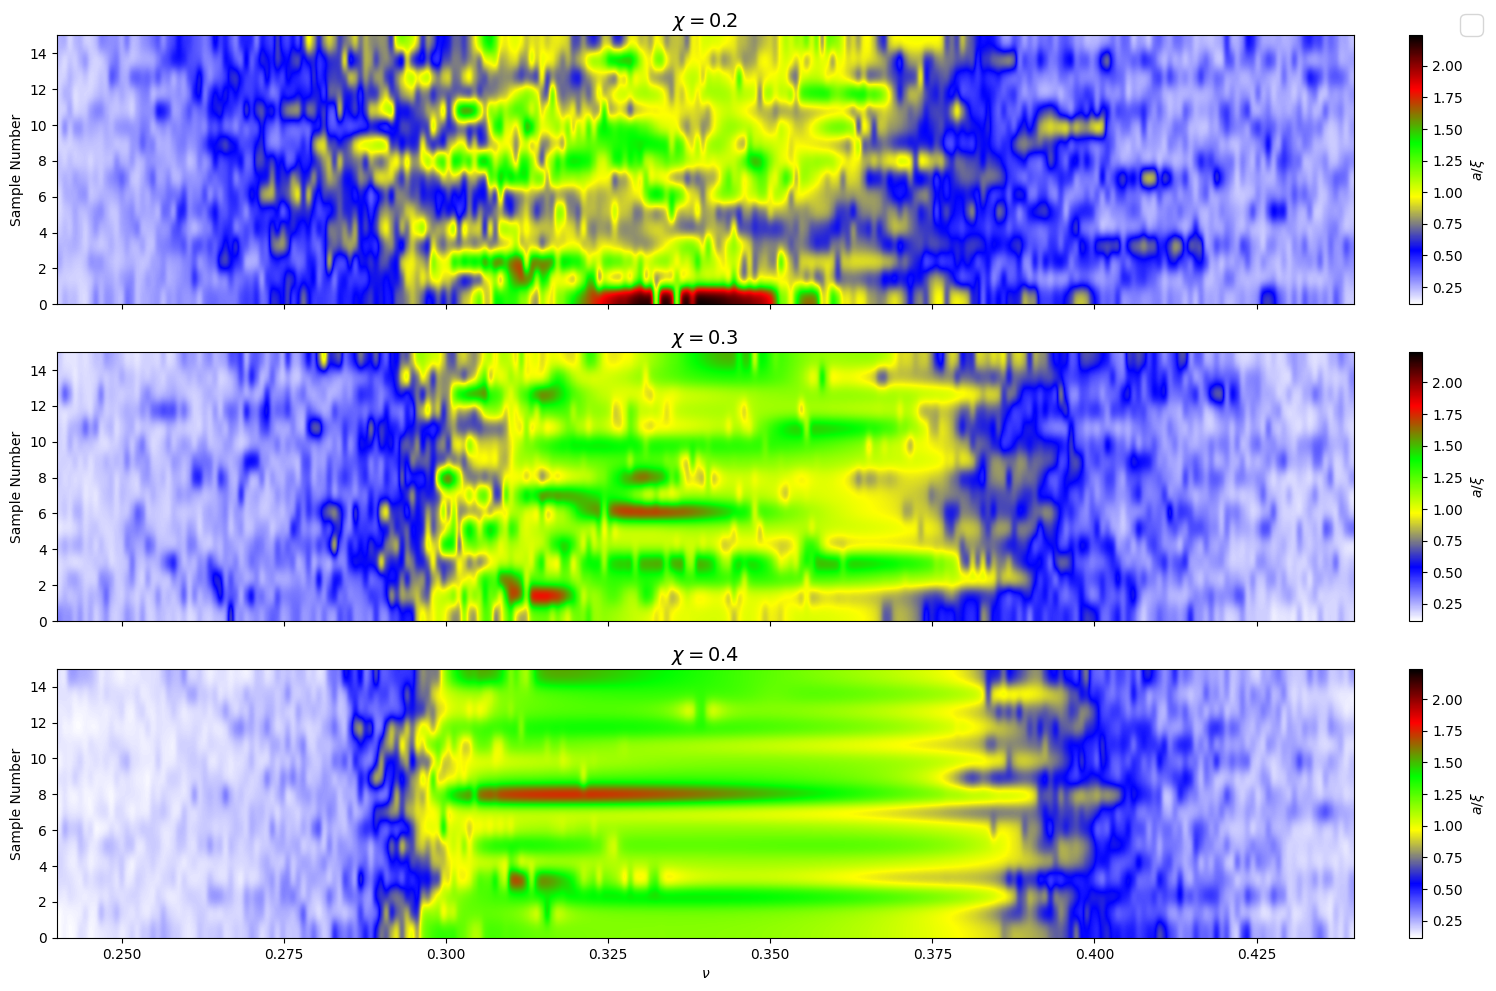

In [21]:
colors = [
          (1, 1, 1),  # White
          (0, 0, 1),  # Blue
          (1, 1, 0),  # Yellow
          (0, 1, 0),  # Green
          (1, 0, 0), #Red
          (0, 0, 0), # Black
          ] 
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
f = (sim_result.sim_data.get_intensity("freq_monitorFieldOut").f)/td.C_0
all_data = np.array([item["xis_slabs"] for i, item in enumerate(data) if chi[i] in [0.2, 0.3, 0.35]])
global_vmin = np.min(all_data)
global_vmax = np.max(all_data)

fig1, axs1 = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)
# fig1, axs1 = plt.subplots(np.shape(data)[0], 1, figsize=(7, 30), sharex=True, sharey=True)
j=0
for i,item in enumerate(data):
 if not chi[i] in [0.2,0.3,0.35]:
   continue
 ax = axs1[j]
 j=j+1
 ax.set_title(rf"$\chi = {item["chi"]}$", fontsize=14)
 im=ax.imshow(np.array(item["xis_slabs"]), vmin = global_vmin, vmax = global_vmax, 
                         extent =[np.min(f),np.max(f), np.min(item["samples"]),np.max(item["samples"])], 
                            interpolation ='gaussian', origin ='lower', cmap=cmap,aspect='auto') 
 cbar = fig1.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04,label=rf"$a/ \xi$")
 ax.set_ylabel(rf"Sample Number")

axs1[-1].set_title(rf"$\chi = {0.4}$", fontsize=14)

plt.xlabel(rf"$\nu$")
fig1.legend(fontsize="20")
plt.tight_layout()

plt.show()

In [28]:
print(np.shape(data))
chi = [0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40]
# chi = [0.3,0.31,0.32,0.33,0.34]


(12,)


In [29]:
for item in data[1:]:
    print(item["chi"])

0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4


In [30]:
field = np.array([(item["xis"]) for item in data[1:]])

In [31]:
np.shape(field)

(11, 250)

In [32]:


# field_loc_length = xr.DataArray(field, coords={"f": (sim_result.sim_data.get_intensity("freq_monitorFieldOut").f)/td.C_0,"chi":np.array(chi)}, dims=["chi","f"],attrs=dict(
#         description=rf"$a/\xi$",
#     ),)


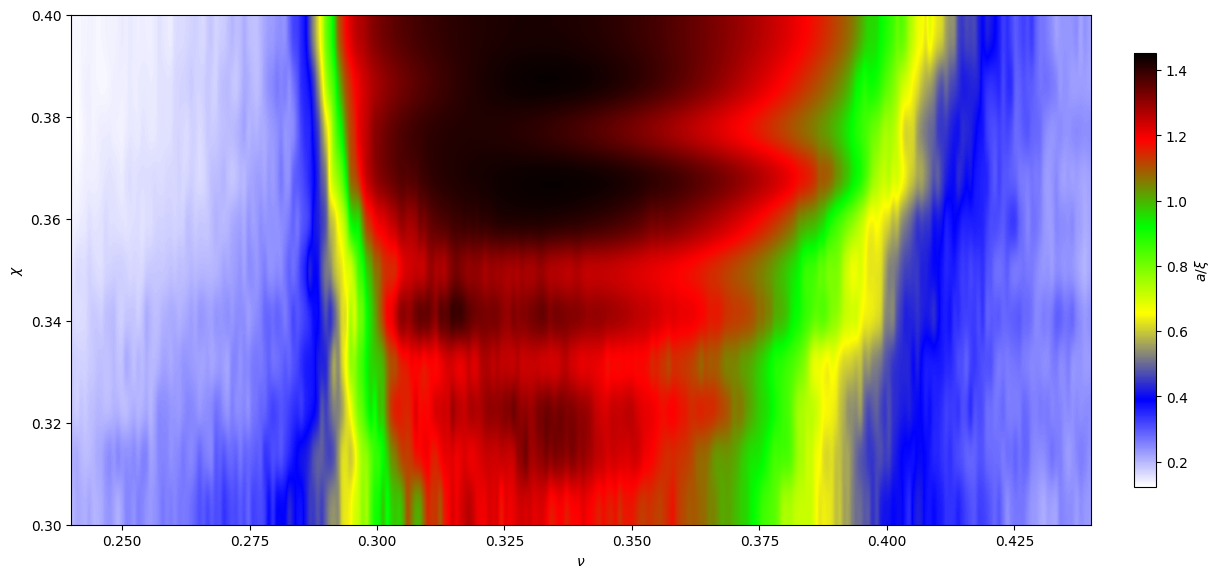

In [36]:
f = (sim_result.sim_data.get_intensity("freq_monitorFieldOut").f)/td.C_0
fig, ax = plt.subplots(figsize=(14,9))
# Define the colors: Blue -> White -> Yellow -> Green -> Red
colors = [
          (1, 1, 1),  # White
          (0, 0, 1),  # Blue
          (1, 1, 0),  # Yellow
          (0, 1, 0),  # Green
          (1, 0, 0), #Red
          (0, 0, 0), # Black
          ]  

# Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

# (field_loc_length).plot.pcolormesh(ax=ax,cmap=cmap)
im=plt.imshow(field, vmin = np.min(field), vmax = np.max(field), 
                 extent =[np.min(f),np.max(f), np.min(chi),np.max(chi)], 
                    interpolation ='gaussian', origin ='lower', cmap=cmap,aspect='equal') 
# Add colorbar for reference
cbar = fig.colorbar(im, ax=ax, label=rf"$a/ \xi$",orientation='vertical', fraction=0.02, pad=0.04)

plt.xlabel(rf"$\nu$")
plt.ylabel(rf"$\chi$")

plt.show()